Packages.

In [1]:
!pip install mat
!pip install jedi==0.10
!pip install numpy==1.22.4
!pip install setuptools==64.0.2
!pip install bambi
!pip install pydataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 11.7 MB/s eta 0:00:00
  Created wheel for mat: filename=mat-1.0.2-py3-none-any.whl size=11694 sha256=12865bb0e1d22ec410488c22098174672e45097f5663c6ab794a390294f98d47
  Stored in directory: /root/.cache/pip/wheels/ec/67/ec/169df41417b32c245f41bc501edcb079c05bda5dad3f1e24e1
Successfully built mat
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.8/186.8 kB 3.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, but you have jedi 0.10.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg

In [1]:
import bambi as bmb
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures


The loan data set has information from loan applications along with whether or not the loan was accepted. 

In [2]:
loan = pd.read_csv("https://richardson.byu.edu/220/loan.csv")
loan

,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Yes,Graduate,No,4583,1508.0,128,360,1,Rural,N
1,Yes,Graduate,Yes,3000,0.0,66,360,1,Urban,Y
2,Yes,Not Graduate,No,2583,2358.0,120,360,1,Urban,Y
3,No,Graduate,No,6000,0.0,141,360,1,Urban,Y
4,Yes,Graduate,Yes,5417,4196.0,267,360,1,Urban,Y
...,...,...,...,...,...,...,...,...,...,...
485,No,Graduate,No,2900,0.0,71,360,1,Rural,Y
486,Yes,Graduate,No,4106,0.0,40,180,1,Rural,Y
487,Yes,Graduate,No,8072,240.0,253,360,1,Urban,Y
488,Yes,Graduate,No,7583,0.0,187,360,1,Urban,Y


Build a standard logistic regression model for the data. 

In [3]:
# Get the target variable
y = (loan.Loan_Status == "Y")
# Get the predictors ready
X = pd.get_dummies(loan.drop(columns = ["Loan_Status"]),drop_first = True)

# Scale the data
scale_for_X = StandardScaler()
scale_for_X.fit(X) 
scaled_X = scale_for_X.transform(X)
scaled_X = pd.DataFrame(scaled_X,columns = X.columns)

# fit a logistic regression model
mod = LogisticRegression()
mod.fit(scaled_X,y)

# check the accuracy
mod.score(scaled_X,y)

0.8142857142857143

In [ ]:
mod.predict_proba(scaled_X)

In [ ]:
np.mean((mod.predict_proba(scaled_X)[:,1] > 0.5) == y)

0.8142857142857143

Now we fit a model with higher order terms

In [4]:
# Define your lists of continuous and categorical column names
continuous_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount','Loan_Amount_Term']
# include variables that are only 0's and 1's in categorical
categorical_cols = ['Married', 'Education','Self_Employed','Credit_History','Property_Area']

# scale continuous columns only
scale_for_conts = StandardScaler()
scale_for_conts.fit(loan[continuous_cols]) 
loan_cont_scaled = scale_for_conts.transform(loan[continuous_cols]) # change data frame name

# Add polynomial features to the continuous columns
poly = PolynomialFeatures(degree=2, include_bias=False)
continuous_data = poly.fit_transform(loan_cont_scaled) # change data frame name
continuous_cols_names = poly.get_feature_names_out(continuous_cols)
X = pd.DataFrame(continuous_data,columns = continuous_cols_names)
X[continuous_cols]

# Create dummy variables and interactions for the categorical columns

X_cont = X[continuous_cols]

# Multiply dummy variables with other variables
for col in categorical_cols:
    temp_dummies = pd.get_dummies(loan[col],prefix = col,drop_first = True) # change data frame name
    temp_col_names = temp_dummies.columns
    for col1 in temp_col_names:
        X_temp = pd.DataFrame(X_cont.multiply(temp_dummies[col1],axis = 0))
        X_temp.columns =  [col1 + col2 for col2 in X_cont.columns]
        X = pd.concat([X,X_temp],axis = 1)
    X_cont = pd.concat([X_cont,temp_dummies],axis = 1)
    X = pd.concat([X,temp_dummies],axis = 1)


X

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,ApplicantIncome^2,ApplicantIncome CoapplicantIncome,ApplicantIncome LoanAmount,ApplicantIncome Loan_Amount_Term,CoapplicantIncome^2,CoapplicantIncome LoanAmount,...,Property_Area_UrbanApplicantIncome,Property_Area_UrbanCoapplicantIncome,Property_Area_UrbanLoanAmount,Property_Area_UrbanLoan_Amount_Term,Property_Area_UrbanMarried_Yes,Property_Area_UrbanEducation_Not Graduate,Property_Area_UrbanSelf_Employed_Yes,Property_Area_UrbanCredit_History_1,Property_Area_Semiurban,Property_Area_Urban
0,-0.134317,-0.024307,-0.205543,0.271446,0.018041,0.003265,0.027608,-0.036460,0.000591,0.004996,...,-0.000000,-0.000000,-0.000000,0.000000,0,0,0,0,0,0
1,-0.416511,-0.605510,-0.982789,0.271446,0.173481,0.252202,0.409342,-0.113060,0.366643,0.595089,...,-0.416511,-0.605510,-0.982789,0.271446,1,0,1,1,0,1
2,-0.490847,0.303294,-0.305833,0.271446,0.240931,-0.148871,0.150117,-0.133238,0.091987,-0.092757,...,-0.490847,0.303294,-0.305833,0.271446,1,1,0,1,0,1
3,0.118284,-0.605510,-0.042572,0.271446,0.013991,-0.071622,-0.005036,0.032108,0.366643,0.025778,...,0.118284,-0.605510,-0.042572,0.271446,0,0,0,1,0,1
4,0.014355,1.011684,1.536993,0.271446,0.000206,0.014523,0.022064,0.003897,1.023504,1.554951,...,0.014355,1.011684,1.536993,0.271446,1,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,-0.434337,-0.605510,-0.920108,0.271446,0.188649,0.262996,0.399637,-0.117899,0.366643,0.557135,...,-0.000000,-0.000000,-0.000000,0.000000,0,0,0,0,0,0
486,-0.219350,-0.605510,-1.308731,-2.488064,0.048114,0.132819,0.287070,0.545756,0.366643,0.792450,...,-0.000000,-0.000000,-0.000000,-0.000000,0,0,0,0,0,0
487,0.487649,-0.513011,1.361485,0.271446,0.237801,-0.250169,0.663927,0.132370,0.263180,-0.698457,...,0.487649,-0.513011,1.361485,0.271446,1,0,0,1,0,1
488,0.400477,-0.605510,0.534094,0.271446,0.160382,-0.242493,0.213893,0.108708,0.366643,-0.323400,...,0.400477,-0.605510,0.534094,0.271446,1,0,0,1,0,1


Everything runs smoothly

In [ ]:
# Fit the model without nan's
mod_temp = sm.Logit(y,sm.add_constant(X)).fit()

mod_temp.summary()

In [ ]:
X_temp = sm.add_constant(X)

# Itertatively remove the largest p value 1 at a time
while max(mod_temp.pvalues) > 0.05 and (len(X_temp.columns) > 1):
  max_pvalue = np.argmax(mod_temp.pvalues[1:])+1
  X_temp = X_temp.drop(columns = X_temp.columns[max_pvalue])
  mod_temp = sm.Logit(y,X_temp).fit()

mod_reduced = mod_temp

# View the final model summary
mod_reduced.summary()

Now we want to fit a Bayes model with these variables. First let's make a new data set with the predictors and the target. 

In [7]:
df = X_temp.copy()
df["y"] = y

We will try using a trick for getting the formula for the Bayesian model. 

In [8]:
formula = 'y  ~ ' + ' + '.join([col for col in X_temp.columns[1:]])
formula

'y  ~ Loan_Amount_Term + ApplicantIncome LoanAmount + ApplicantIncome Loan_Amount_Term + CoapplicantIncome^2 + CoapplicantIncome LoanAmount + Loan_Amount_Term^2 + Education_Not GraduateCoapplicantIncome + Self_Employed_YesLoanAmount + Credit_History_1 + Property_Area_SemiurbanCredit_History_1'

It doesn't work because there are some un allowed characters. 

In [ ]:
mod_bayes = bmb.Model(formula,df)

ScanError: ignored

This is better, using tick marks around the variables. \`variable\`

In [9]:
formula = 'y  ~ ' + ' + '.join(['`' + col + '`' for col in X_temp.columns[1:]])
formula

'y  ~ `Loan_Amount_Term` + `ApplicantIncome LoanAmount` + `ApplicantIncome Loan_Amount_Term` + `CoapplicantIncome^2` + `CoapplicantIncome LoanAmount` + `Loan_Amount_Term^2` + `Education_Not GraduateCoapplicantIncome` + `Self_Employed_YesLoanAmount` + `Credit_History_1` + `Property_Area_SemiurbanCredit_History_1`'

In [10]:
mod_bayes = bmb.Model(formula,df)
results = mod_bayes.fit(draws=200, chains=2)


Priors

In [11]:
priors = {var:bmb.Prior("Normal",mu = 0,sigma = 1) for var in results.posterior.data_vars}

# The BPM_sigma is a variable in the model that we don't need to give a normal prior
del priors["y_sigma"]
priors

{'Intercept': Normal(mu: 0.0, sigma: 1.0),
 'Loan_Amount_Term': Normal(mu: 0.0, sigma: 1.0),
 'ApplicantIncome LoanAmount': Normal(mu: 0.0, sigma: 1.0),
 'ApplicantIncome Loan_Amount_Term': Normal(mu: 0.0, sigma: 1.0),
 'CoapplicantIncome^2': Normal(mu: 0.0, sigma: 1.0),
 'CoapplicantIncome LoanAmount': Normal(mu: 0.0, sigma: 1.0),
 'Loan_Amount_Term^2': Normal(mu: 0.0, sigma: 1.0),
 'Education_Not GraduateCoapplicantIncome': Normal(mu: 0.0, sigma: 1.0),
 'Self_Employed_YesLoanAmount': Normal(mu: 0.0, sigma: 1.0),
 'Credit_History_1': Normal(mu: 0.0, sigma: 1.0),
 'Property_Area_SemiurbanCredit_History_1': Normal(mu: 0.0, sigma: 1.0)}

Fit the Bayes model and view the results. 

In [12]:
mod_bayes = bmb.Model(formula,df)
mod_bayes.set_priors(priors=priors)
results = mod_bayes.fit(draws=1000, chains=2)
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.136,0.047,0.047,0.223,0.001,0.001,3376.0,1579.0,1.0
Loan_Amount_Term,-0.093,0.028,-0.145,-0.040,0.001,0.000,2228.0,1685.0,1.0
ApplicantIncome LoanAmount,-0.014,0.007,-0.027,-0.000,0.000,0.000,3350.0,1793.0,1.0
ApplicantIncome Loan_Amount_Term,-0.073,0.021,-0.111,-0.035,0.000,0.000,3130.0,1483.0,1.0
CoapplicantIncome^2,-0.006,0.002,-0.011,-0.002,0.000,0.000,3871.0,1793.0,1.0
CoapplicantIncome LoanAmount,-0.030,0.013,-0.054,-0.006,0.000,0.000,3495.0,1393.0,1.0
Loan_Amount_Term^2,-0.030,0.010,-0.050,-0.013,0.000,0.000,2215.0,1542.0,1.0
Education_Not GraduateCoapplicantIncome,0.174,0.077,0.045,0.336,0.001,0.001,3643.0,1330.0,1.0
Self_Employed_YesLoanAmount,0.073,0.038,-0.003,0.142,0.001,0.001,3893.0,1821.0,1.0
Credit_History_1,0.654,0.050,0.558,0.745,0.001,0.001,3409.0,1545.0,1.0


Make predictions. These are the means of the probabilities of acceptance. 

In [15]:
mod_bayes.predict(results)
results.posterior.y_mean[0,:,0]

<xarray.DataArray 'y_mean' (draw: 1000)>
array([0.79777139, 0.80699211, 0.749285  , 0.81335525, 0.7322367 ,
       0.76132121, 0.79171172, 0.75159748, 0.74916587, 0.79108679,
       0.75751654, 0.77270661, 0.75709315, 0.77498953, 0.75010528,
       0.75447646, 0.76493623, 0.77273941, 0.75640201, 0.78020815,
       0.7902898 , 0.74359922, 0.76822082, 0.76793683, 0.80474056,
       0.76962398, 0.78024498, 0.75917712, 0.75485476, 0.78605203,
       0.76267604, 0.73036232, 0.77771029, 0.78772502, 0.75179973,
       0.80059471, 0.7512991 , 0.77722362, 0.73844909, 0.7526077 ,
       0.81628476, 0.71716134, 0.80656855, 0.75405018, 0.77468195,
       0.75139015, 0.73416092, 0.74144736, 0.7874015 , 0.77191185,
       0.74034337, 0.73610365, 0.78737707, 0.78737707, 0.77862476,
       0.7241663 , 0.81219155, 0.72622116, 0.7897801 , 0.75590411,
       0.76430909, 0.76539117, 0.75278006, 0.81101131, 0.72417163,
       0.76265335, 0.78175538, 0.75277421, 0.73052073, 0.74334802,
       0.74433382, 0.76109331, 0.75489084, 0.80019811, 0.77726081,
       0.75259207, 0.79159144, 0.74410222, 0.78284608, 0.74505303,
       0.76711108, 0.76790522, 0.75386243, 0.77143245, 0.74235625,
       0.72217213, 0.70602815, 0.7894426 , 0.71857309, 0.77641141,
       0.76490996, 0.7624226 , 0.78464229, 0.74906113, 0.79355907,
       0.70717097, 0.76644336, 0.77437056, 0.75306776, 0.74987756,
...
       0.77003165, 0.76543606, 0.75993034, 0.73932072, 0.76287366,
       0.76076559, 0.7740715 , 0.78007158, 0.75619273, 0.75400838,
       0.69088593, 0.7139146 , 0.84395299, 0.69932277, 0.80501317,
       0.72335949, 0.74146768, 0.74058287, 0.73731912, 0.80818299,
       0.76424008, 0.76292414, 0.76219906, 0.78203937, 0.72829211,
       0.78332921, 0.73321628, 0.72223355, 0.76346552, 0.7550783 ,
       0.76685797, 0.78401976, 0.71009132, 0.80473763, 0.73703361,
       0.72277475, 0.76880043, 0.72216387, 0.77736064, 0.76464335,
       0.75483953, 0.76450319, 0.75219305, 0.78044139, 0.73141216,
       0.72742925, 0.72797119, 0.77733151, 0.76099877, 0.75652314,
       0.78555339, 0.74371802, 0.76668497, 0.7751471 , 0.69627673,
       0.82438747, 0.81111227, 0.81964377, 0.80712481, 0.76785858,
       0.77441109, 0.7666715 , 0.80305924, 0.75258466, 0.76984951,
       0.75023811, 0.74483416, 0.75385261, 0.75721015, 0.75305997,
       0.7663192 , 0.7663192 , 0.76294931, 0.73541882, 0.79375745,
       0.72699455, 0.80483444, 0.71471661, 0.73802974, 0.8297277 ,
       0.73663283, 0.73719607, 0.78108244, 0.7385252 , 0.80336781,
       0.75524972, 0.78216863, 0.76599175, 0.82124605, 0.70074514,
       0.69859618, 0.81957779, 0.75600512, 0.76044247, 0.79340983,
       0.76341391, 0.7750217 , 0.75212792, 0.77989896, 0.76601746])
Coordinates:
    chain    int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
    y_obs    int64 0

In [ ]:
mod_bayes.predict(results)
pred_array = np.array(results.posterior.y_mean)
#print(pred_array.mean(axis = (0,1))) # mean prediction for all 490 points
print(pred_array[0,0,:])

[ 0.76621559  0.64600761  0.76753855  0.75669364  0.87240977  0.77142426
  0.16751661  0.77073815  0.42981865  0.75773298  0.67700284  0.77787022
  0.44404047  0.75782554  0.14530498  0.77445692  0.15529393  0.64730843
  0.16597138  0.92123631  0.8914034   0.76923147  0.7542507   0.75007669
  0.70453648  0.88731196  0.64882183  0.88828172  0.70099121  0.88539403
  0.75089425  0.76157493  0.88680722  0.73995144  0.75801837  0.16962584
  0.88621235  0.89008889  0.88077513  0.87477014  0.76112535  0.30740797
  0.88523332  0.88942816  0.77181694  0.74375152  0.7582001   0.7740619
  0.75752807  0.05702785  0.15386498  0.82183544  0.07248142  0.7350129
  0.69814351  0.1582034   0.76708232  0.82729727  0.88145718  0.93558204
  0.61283588  0.74662989  0.73607637  0.1604199   0.87576098  0.78358055
  0.7449722   0.89305068  0.8916284   0.75085563  0.8600039   0.89028604
  0.88106395  0.76732442  0.87754607  0.69959527  0.89282905  0.87649936
  0.84634096  0.89341754  0.71127602  0.87485899  0.7

In [ ]:
(pred_array.mean(axis = (0,1)) > 0.5)

array([ True,  True,  True,  True,  True,  True, False,  True, False,
        True,  True,  True,  True,  True, False,  True, False,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True, False, False,  True, False,  True,
        True, False,  True,  True,  True,  True, False,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,

In [ ]:
np.mean((pred_array.mean(axis = (0,1)) > 0.5) == y)

0.826530612244898

Examine the histogram of the posterior predicted mean distribution for just one of the variables. 

(array([  8.,  21.,  68., 173., 263., 265., 135.,  51.,  12.,   4.]),
 array([0.5367751 , 0.57852791, 0.62028072, 0.66203353, 0.70378634,
        0.74553915, 0.78729196, 0.82904477, 0.87079757, 0.91255038,
        0.95430319]),
 <BarContainer object of 10 artists>)

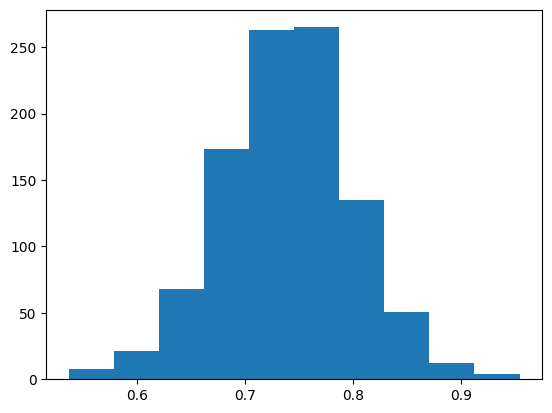

In [ ]:
plt.hist(pred_array[0,:,101])

In [ ]:
np.quantile(pred_array[0,:,103],[.025,.975])

array([0.65809277, 0.79947483])

In [ ]:
np.mean(pred_array[0,:,103])

0.72774984716181

In [ ]:
y[103]

True